### ==============================================================================
### 🚀 FINAL SCENARIO: Combining Improvements for Maximum Impact
### ==============================================================================

This scenario will find the worst-case production runs—those with both high downtime and low-quality raw materials—and then simulate the outcome if those exact runs were optimized with both low downtime and high-quality materials.

This answers the ultimate business question: `What is the total potential improvement if we follow the model's top recommendations?`

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
print("1. Loading the saved model preprocessor, and original test data...")

# Load the pre-trained model and the preprocessor
loaded_model = joblib.load("../model/defect_rate_predictor.joblib")
loaded_preprocessor = joblib.load("../model/preprocessor.joblib")

print("✅ Model and preprocessor loaded successfully.")

1. Loading the saved model preprocessor, and original test data...
✅ Model and preprocessor loaded successfully.


In [3]:
# Load the raw dataset to get the original, untransformed test data
df_raw = pd.read_csv("../data/smart_phone_surface_plastic_manufacture.csv")
X = df_raw.drop(columns=['Defect Rate (%)', 'Production Output (Units)', 'Unnamed: 0', 'Production Run ID', 'Date'])
y = df_raw['Defect Rate (%)'].dropna()

In [4]:
# Split the data into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X.loc[y.index], y, test_size=0.2, random_state=42)


--- Combined Business Impact Simulation ---
Average Predicted Defect Rate for 'Worst-Case' Runs: 10.05%
Predicted Rate if BOTH Downtime & Quality are Optimized: 3.06%
--------------------------------------------------
✅ By implementing the model's top two recommendations, we can predict an average improvement of 6.99 percentage points in the defect rate for our most problematic runs.


/var/folders/tm/lpcq7lb52_xblwgjpmlk5mh00000gn/T/ipykernel_88786/631329736.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Average Predicted Defect Rate (%)', y='Scenario', data=viz_df, palette='cividis')


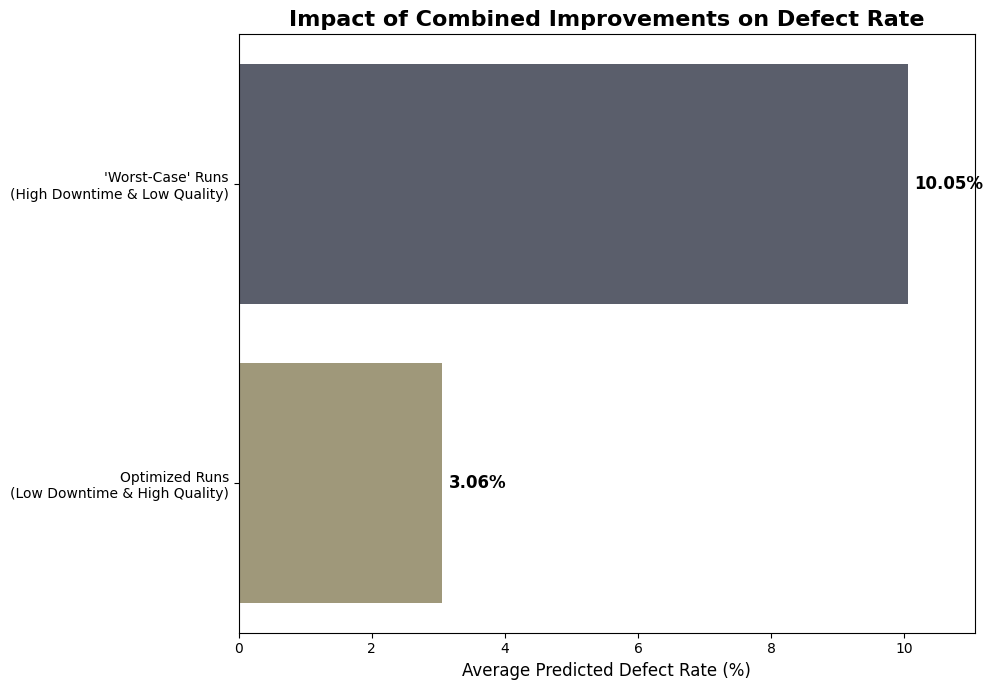

In [5]:
# --- 2. Identify "Worst-Case" Runs from the Real Test Set ---
# Runs with downtime > 60 minutes AND material quality < 80
worst_case_runs = X_test_raw[
    (X_test_raw['Downtime (Minutes)'] > 60) &
    (X_test_raw['Raw Material Quality (Score)'] < 80)
].copy()

if worst_case_runs.empty:
    print("No 'worst-case' runs found in the test set to simulate. Please adjust the thresholds if needed.")
else:
    # --- 3. Create a "Simulated Best-Case" Version of These Runs ---
    # What if these runs had low downtime AND high-quality materials?
    simulated_best_case_runs = worst_case_runs.copy()
    simulated_best_case_runs['Downtime (Minutes)'] = 15.0  # Low downtime
    simulated_best_case_runs['Raw Material Quality (Score)'] = 95.0 # High quality

    # --- Re-engineer features for both groups ---
    for df in [worst_case_runs, simulated_best_case_runs]:
        df['Energy_per_Unit'] = df['Energy Consumption (kWh)'] / (df['Batch Size (Units)'] + 1e-6)
        df['Process_Stress_Index'] = df['Temperature (°C)'] * df['Pressure (Pa)']

    # --- 4. Preprocess and Predict for Both Groups ---
    original_processed = loaded_preprocessor.transform(worst_case_runs)
    simulated_processed = loaded_preprocessor.transform(simulated_best_case_runs)

    # Get column names to create DataFrames for dropping features
    ohe_feature_names = loaded_preprocessor.named_transformers_['cat'].get_feature_names_out()
    all_feature_names = (
        list(loaded_preprocessor.named_transformers_['skewed'].feature_names_in_) +
        list(loaded_preprocessor.named_transformers_['symmetric'].feature_names_in_) +
        list(ohe_feature_names)
    )
    original_processed_df = pd.DataFrame(original_processed, columns=all_feature_names)
    simulated_processed_df = pd.DataFrame(simulated_processed, columns=all_feature_names)

    cols_to_drop = ['Process_Stress_Index', 'Pressure (Pa)']
    original_final = original_processed_df.drop(columns=cols_to_drop)
    simulated_final = simulated_processed_df.drop(columns=cols_to_drop)

    original_predicted_defects = loaded_model.predict(original_final)
    simulated_predicted_defects = loaded_model.predict(simulated_final)

    # --- 5. Display the Combined Business Impact ---
    avg_original_defect_rate = np.mean(original_predicted_defects)
    avg_simulated_defect_rate = np.mean(simulated_predicted_defects)
    improvement = avg_original_defect_rate - avg_simulated_defect_rate

    print("\n--- Combined Business Impact Simulation ---")
    print(f"Average Predicted Defect Rate for 'Worst-Case' Runs: {avg_original_defect_rate:.2f}%")
    print(f"Predicted Rate if BOTH Downtime & Quality are Optimized: {avg_simulated_defect_rate:.2f}%")
    print("-" * 50)
    print(f"✅ By implementing the model's top two recommendations, we can predict an average improvement of {improvement:.2f} percentage points in the defect rate for our most problematic runs.")

    # --- 6. Final Visualization for Management ---
    viz_data = {
        'Scenario': ["'Worst-Case' Runs\n(High Downtime & Low Quality)", "Optimized Runs\n(Low Downtime & High Quality)"],
        'Average Predicted Defect Rate (%)': [avg_original_defect_rate, avg_simulated_defect_rate]
    }
    viz_df = pd.DataFrame(viz_data)

    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x='Average Predicted Defect Rate (%)', y='Scenario', data=viz_df, palette='cividis')
    for p in ax.patches:
        ax.annotate(f"{p.get_width():.2f}%", (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=12, fontweight='bold')
    plt.title('Impact of Combined Improvements on Defect Rate', fontsize=16, fontweight='bold')
    plt.xlabel('Average Predicted Defect Rate (%)', fontsize=12)
    plt.ylabel('')
    plt.xlim(0, avg_original_defect_rate * 1.1)
    plt.tight_layout()
    plt.savefig('../images/combined_business_impact.png')
    plt.show()
    plt.close()